In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV

In [19]:
origin_train = pd.read_csv('train.csv')
print('read train end')
origin_test = pd.read_csv('test.csv')
print('read test end')

read train end
read test end


In [20]:
def get_new_feature():
    """
    targetとの相関が高い新しい特徴量を作成する
    """
    
    #相関0.０７以上
    border= 0.07
    
    best_corr_var = pd.read_csv("best_corr_var.csv").rename(columns={"Unnamed: 0":"ID_code", "0":"corr"})
    #相関で並び替え→上位を取得
    var_name_li = best_corr_var.sort_values("corr", ascending=False)[best_corr_var["corr"]>border]["ID_code"]
    id_code_li = []
    for var_name in var_name_li.values:
        id_code_li.append(var_name.replace("var_", "").split("_"))
    
    #新しい特徴量の作成
    new_train = pd.DataFrame([])
    new_test = pd.DataFrame([])
    for id_code_pair in id_code_li:
        var1 = f"var_{id_code_pair[0]}"
        var2 = f"var_{id_code_pair[1]}"
        new_train_feature = origin_train[var1] + origin_train[var2]
        new_test_feature = origin_test[var1] + origin_test[var2]
        
        new_train = pd.concat([new_train, new_train_feature], axis=1)
        new_test = pd.concat([new_test, new_test_feature], axis=1)
    
    return new_train, new_test, var_name_li

In [21]:
new_train, new_test, var_name = get_new_feature()
new_train.columns = var_name.values
new_test.columns = var_name.values

/Users/Takashi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


In [22]:
target = origin_train["target"]
train = pd.concat([origin_train, new_train], axis=1)
test = pd.concat([origin_test, new_test], axis=1)

In [23]:
positive_count_train = train['target'].sum()

In [24]:
rus = RandomUnderSampler(ratio={0:positive_count_train*1, 1:positive_count_train}, random_state=0)
X_train_resampled, y_train_resampled = rus.fit_sample(train[train.columns[2:]], train['target'])

In [25]:
features = train.columns[2:]
y_train_df = pd.DataFrame(y_train_resampled, columns=['target'])
train = pd.DataFrame(X_train_resampled, columns=features)

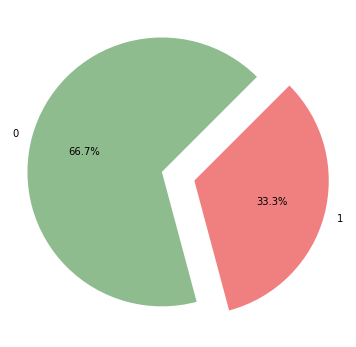

In [26]:
colors = ['darkseagreen','lightcoral']
plt.figure(figsize=(6,6))
plt.pie(y_train_df['target'].value_counts(), explode=(0, 0.25), labels= ["0", "1"],
        startangle=45, autopct='%1.1f%%', colors=colors)
plt.axis('equal')
plt.show()

In [27]:
target = y_train_df['target']

In [28]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)
    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)
    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [29]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': 2,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [ ]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
#     trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx])
    trn_train, trn_target= augment(np.array(train.iloc[trn_idx]), np.array(target.iloc[trn_idx]))
    trn_data = lgb.Dataset(trn_train, label=trn_target)
#     val_train, val_target= augment(np.array(train.iloc[val_idx]), np.array(target.iloc[val_idx]))
#     val_data = lgb.Dataset(val_train, label=val_target)

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train.iloc[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = features
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.874171	valid_1's auc: 0.76017
[2000]	training's auc: 0.896727	valid_1's auc: 0.797671
[3000]	training's auc: 0.908958	valid_1's auc: 0.817909
[4000]	training's auc: 0.916679	valid_1's auc: 0.830402
[5000]	training's auc: 0.922189	valid_1's auc: 0.839799
[6000]	training's auc: 0.926349	valid_1's auc: 0.846633
[7000]	training's auc: 0.929571	valid_1's auc: 0.851737
[8000]	training's auc: 0.932106	valid_1's auc: 0.855871
[9000]	training's auc: 0.934273	valid_1's auc: 0.859153
[10000]	training's auc: 0.936061	valid_1's auc: 0.861913
[11000]	training's auc: 0.937574	valid_1's auc: 0.864384
[12000]	training's auc: 0.938907	valid_1's auc: 0.866314
[13000]	training's auc: 0.94008	valid_1's auc: 0.867807
[14000]	training's auc: 0.94115	valid_1's auc: 0.869295
[15000]	training's auc: 0.942143	valid_1's auc: 0.870791
[16000]	training's auc: 0.943057	valid_1's auc: 0.872039
[17000]	training's auc: 0.943

[40000]	training's auc: 0.957206	valid_1's auc: 0.896424
[41000]	training's auc: 0.957655	valid_1's auc: 0.89649
[42000]	training's auc: 0.958119	valid_1's auc: 0.896592
[43000]	training's auc: 0.958591	valid_1's auc: 0.896705
[44000]	training's auc: 0.959074	valid_1's auc: 0.896777
[45000]	training's auc: 0.959525	valid_1's auc: 0.896813
[46000]	training's auc: 0.959945	valid_1's auc: 0.896851
[47000]	training's auc: 0.960405	valid_1's auc: 0.896875
[48000]	training's auc: 0.960821	valid_1's auc: 0.896959
[49000]	training's auc: 0.961274	valid_1's auc: 0.897019
[50000]	training's auc: 0.961675	valid_1's auc: 0.897068
[51000]	training's auc: 0.962109	valid_1's auc: 0.897076
[52000]	training's auc: 0.962509	valid_1's auc: 0.897059
[53000]	training's auc: 0.962909	valid_1's auc: 0.897094
[54000]	training's auc: 0.963313	valid_1's auc: 0.897081
[55000]	training's auc: 0.963725	valid_1's auc: 0.897047
[56000]	training's auc: 0.964105	valid_1's auc: 0.896988
[57000]	training's auc: 0.964499

[5000]	training's auc: 0.92207	valid_1's auc: 0.842212
[6000]	training's auc: 0.92623	valid_1's auc: 0.848509
[7000]	training's auc: 0.929391	valid_1's auc: 0.853198
[8000]	training's auc: 0.931996	valid_1's auc: 0.85697
[9000]	training's auc: 0.934178	valid_1's auc: 0.860169
[10000]	training's auc: 0.935998	valid_1's auc: 0.862979
[11000]	training's auc: 0.937479	valid_1's auc: 0.86485
[12000]	training's auc: 0.938833	valid_1's auc: 0.866913
[13000]	training's auc: 0.939986	valid_1's auc: 0.86833
[14000]	training's auc: 0.941085	valid_1's auc: 0.869886
[15000]	training's auc: 0.942102	valid_1's auc: 0.871275
[16000]	training's auc: 0.942991	valid_1's auc: 0.872298
[17000]	training's auc: 0.943835	valid_1's auc: 0.87346
[18000]	training's auc: 0.944694	valid_1's auc: 0.874383
[19000]	training's auc: 0.945459	valid_1's auc: 0.87506
[20000]	training's auc: 0.946231	valid_1's auc: 0.876024
[21000]	training's auc: 0.94694	valid_1's auc: 0.876587
[22000]	training's auc: 0.947631	valid_1's a

In [ ]:
cols = (feature_importance[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:6000].index)
best_features = feature_importance.loc[feature_importance.Feature.isin(cols)]

plt.figure(figsize=(14,30))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()